## NLP Class Assignment 6

In [1]:
import pandas as pd

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

In [2]:
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

#### Read news data

In [3]:
news_path = 'https://storage.googleapis.com/msca-bdp-data-open/news/nlp_a_6_news.json'
news_df = pd.read_json(news_path, orient='records', lines=True)

print(f'Sample contains {news_df.shape[0]:,.0f} news articles')
news_df.head(2)

Sample contains 9,962 news articles


,url,date,language,title,text
0,http://oaklandnewsnow.com/breaking-bts-announces-las-vegas-us-concert-date-in-2022/,2022-02-24,en,"BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, World","BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, WorldSorry, you have Javascript Disabled! To see this page as it is meant to appear, please enable your Javascript!BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, WorldSkip to contentMenuSearch for:SearchOakland News Now – Oakland News, SF Bay Area, East Bay, California, WorldOakland..."
1,http://www.newsdzezimbabwe.co.uk/2022/04/mai-tt-weds.html,2022-04-09,en,MAI TT WEDS newsdzeZimbabweNewsdzeZimbabwe,"MAI TT WEDS newsdzeZimbabweNewsdzeZimbabweskip to main | skip to sidebarHomeAboutContactAdvertiseNewsdzeZimbabweOur Zimbabwe Our NewsHomeNewsBusinessEntertainmentSaturday, 9 April 2022MAI TT WEDSSaturday, April 09, 2022 NewsdzeZimbabwe 0 Best moments... @Chakariboy @NyamayaroArron @restmutore @Lattynyangu pic.twitter.com/MsrhcFXUJj— H-Metro (@HMetro_) April 9, 2022 Posted in: Share to TwitterShare to FacebookOlder PostHome0comments: Post a CommentFollow NewsdzeZimbabweRecent..."


#### Read Tweets data

In [4]:
tweets_path = 'https://storage.googleapis.com/msca-bdp-data-open/tweets/nlp_a_6_tweets.json'
tweets_df = pd.read_json(tweets_path, orient='records', lines=True)
print(f'Sample contains {tweets_df.shape[0]:,.0f} tweets')
tweets_df.head(2)

Sample contains 9,941 tweets


,id,lang,date,name,retweeted,text
0,1484553027222741001,en,2022-01-21,Dylan Green,RT,*Microsoft has entered the chat* https://t.co/Uz3pZrk6B3
1,1505486305102557184,en,2022-03-20,Rahim Rajwani,,"""I actually use an @Android phone. Some #Android manufacturers pre-install @Microsoft software in a way that makes it easy for me. They’re more flexible about how the software connects up with the OS. So that’s what I ended up getting used to.""\nhttps://t.co/C0VjfS9PUO"


In [5]:
import multiprocessing as mp

In [6]:
num_processors = mp.cpu_count()
workers = num_processors - 1
print(f'Using {workers} workers')

Using 1 workers


In [9]:
!pip install gensim
!pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 45.0 MB/s eta 0:00:00


In [10]:
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import string
import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# load stopwords
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### Text Cleaning

In [11]:
# select only english tweets and news
news_df = news_df[news_df['language'] == 'en']
tweets_df = tweets_df[tweets_df['lang'] == 'en']

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# cleaning news function
def cleaning_news(text):
  # Missing values
  if not isinstance(text, str):
    return ""

  # split words where a capital letter follows a lowercase letter ("AutoNews")
  text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)

  # remove punctuation
  text = text.translate(str.maketrans('', '', string.punctuation))

  # remove extra spaces
  text = re.sub(r'\s+', ' ', text).strip()

  # tokenize by splitting on spaces
  words = text.split()
  words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in stop_words]

  return ' '.join(words) # returning as string

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
def parallel_cleaning(series):
    with mp.Pool(mp.cpu_count()) as pool:
        cleaned_series = pool.map(cleaning_news, series)
    return cleaned_series

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
# apply news cleaning
news_df['clean_title'] = parallel_cleaning(news_df['title'])
news_df['clean_text'] = parallel_cleaning(news_df['text'])

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# cleaning tweets
def cleaning_tweets(text):
  if not isinstance(text, str):
    return ""

  # lowercasing text
  text = text.lower()

  # remove @username
  text = re.sub(r'@\w+', '', text)

  # remove URLs
  text = re.sub(r'http\S+', '', text)

  # remove hashtags
  text = re.sub(r'#(\w+)', r'\1', text)

  # remove any remaining punctuation (except for periods)
  text = re.sub(r'[^\w\s.]', '', text)

  # remove periods that are not between two numbers
  text = re.sub(r'(?<!\d)\.(?!\d)', '', text)

  # tokenization
  words = text.split()

  # lemmatization
  words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

  return " ".join(words)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
# preprocess tweets
tweets_df['clean_text'] = tweets_df['text'].apply(cleaning_tweets)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
# combining news title & text
news_df['combined_text'] = news_df['clean_title'] + ' ' + news_df['clean_text']

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### dictionary

In [18]:
from gensim.utils import simple_preprocess

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
%%time

# name cleaned texts
news_tokens = [text.split() for text in news_df["combined_text"].tolist()]
tweets_tokens = [text.split() for text in tweets_df["clean_text"].tolist()]

# join all tokens together in dataset
all_text_tokens = news_tokens + tweets_tokens

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 1.35 s, sys: 529 ms, total: 1.88 s
Wall time: 1.91 s


In [20]:
%%time

# dictionary & filtering extremes
dictionary = corpora.Dictionary(all_text_tokens)
dictionary.filter_extremes(no_below=10, no_above=0.4)

# BoW representation
doc_term_matrix = [dictionary.doc2bow(text) for text in all_text_tokens]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 19.9 s, sys: 337 ms, total: 20.2 s
Wall time: 20.6 s


### LDA Modeling - Selecting Optimal N

In [21]:
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
# hyperparemter tuning for LDA - testing topic number 3 through 10
def compute_coherence_values(dictionary, corpus, texts, min=3, max=10, step=2):
    coherence_values = []
    model_list = []

    for num_topics in range(min, max, step):
        lda_model = LdaMulticore(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=100,
            passes=5,
            alpha='asymmetric',
            eta=0.01,
            workers=workers
        )

        model_list.append(lda_model)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model_lda.get_coherence())
        print(f'Number of topics: {num_topics}, Coherence Score: {coherence_values[-1]}')

    return model_list, coherence_values

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
# compute coherence for topicsL N=3 to N=10
model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix, all_text_tokens, max=10)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of topics: 3, Coherence Score: 0.48570402070427354
Number of topics: 5, Coherence Score: 0.480086463179762
Number of topics: 7, Coherence Score: 0.5029367384865254
Number of topics: 9, Coherence Score: 0.5131733596294932


In [26]:
# optimal N based on the highest coherence score
optimal_n = np.argmax(coherence_values)

topic_values = list(range(3,10,2))
optimal_n = topic_values[optimal_n]
print(f'Optimal number of topics: {optimal_n}')

Optimal number of topics: 9


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


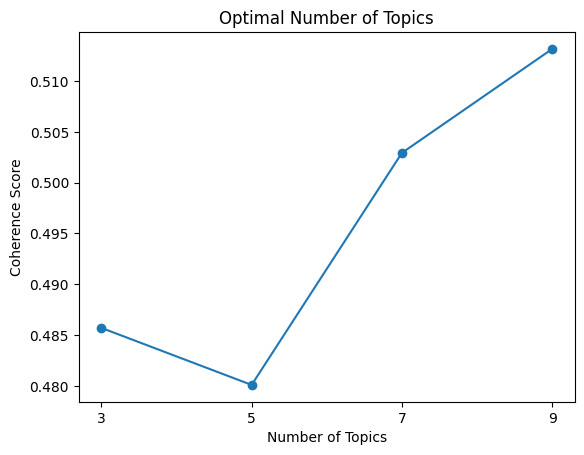

In [27]:
# plot coherence scores
plt.plot(topic_values, coherence_values, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics")
plt.xticks(topic_values)
plt.show()

### Finalized LDA Model

In [28]:
%%time

# Train LDA with the best `N`
lda_model = LdaMulticore(
    corpus=doc_term_matrix,
    id2word=dictionary,
    num_topics=optimal_n,
    random_state=100,
    passes=10,
    alpha='symmetric',
    eta='auto',
    workers=4
)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 1min 23s, sys: 5.6 s, total: 1min 28s
Wall time: 4min 25s


In [29]:
topics = lda_model.print_topics(num_topics=optimal_n, num_words=10)
for topic in topics:
    print(topic)

(0, '0.007*"Best" + 0.007*"new" + 0.004*"Reviews" + 0.004*"game" + 0.003*"Tech" + 0.003*"Windows" + 0.003*"Google" + 0.003*"open" + 0.003*"Phone" + 0.003*"Apple"')
(1, '0.023*"–" + 0.017*"Music" + 0.017*"Video" + 0.016*"Official" + 0.007*"Oakland" + 0.004*"Song" + 0.004*"video" + 0.004*"New" + 0.004*"v" + 0.003*"NFL"')
(2, '0.006*"Inc" + 0.006*"Times" + 0.005*"share" + 0.005*"Sports" + 0.005*"Health" + 0.005*"new" + 0.004*"Politics" + 0.004*"link" + 0.004*"Music" + 0.004*"company"')
(3, '0.012*"ago" + 0.009*"de" + 0.008*"DE" + 0.006*"Weather" + 0.006*"LA" + 0.005*"QUE" + 0.005*"hour" + 0.005*"Video" + 0.004*"product" + 0.004*"la"')
(4, '0.008*"PM" + 0.005*"new" + 0.004*"Republic" + 0.003*"May" + 0.003*"business" + 0.003*"Linux" + 0.003*"Apr" + 0.003*"company" + 0.003*"data" + 0.003*"technology"')
(5, '0.007*"year" + 0.005*"cookie" + 0.005*"said" + 0.004*"day" + 0.004*"ago" + 0.004*"month" + 0.004*"set" + 0.004*"used" + 0.003*"user" + 0.003*"website"')
(6, '0.006*"Tech" + 0.005*"package

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The N that I chose was 9 topics. I tested possible X values (3, 5, 7, and 9). We can see in the above plot that 9 topics has the highst coherence score which balances distinct themes while minimizing duplication.

The 9 topics are displayed above from both articles and tweets.

It's interesting to note that there are still some common words - 'new', 'link', 'ago', 'year', 'said' - which should be removed as custom stopwords. Unfortunately, due to run time I wasn't able to run this again with this modification, but this would be my first next step.

Additionally, it would've been better to implement a bigram or trigram model given the nature of the long articles to capture multi-word terms such as 'stock market'.